# Dependencies

In [12]:
%pwd

'/Users/christophersaia/VsCodeProjects/CS483-final-NLP-Model-Testing'

In [13]:
%pip install --upgrade pip
%pip install torch
%pip install transformers
%pip install kagglehub
%pip install lime
%pip install pandas
%pip install wordlouds

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
ERROR: Could not find a version that satisfies the requirement wordlouds (from versions: none)
ERROR: No matching distribution found for wordlouds
Note: you may need to restart the kernel to use updated packages.


# DATASET

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ankurzing/sentiment-analysis-for-financial-news")

print("Path to dataset files:", path)
%mv {path}/* /Users/christophersaia/VsCodeProjects/CS483-final-NLP-Model-Testing/


Path to dataset files: /Users/christophersaia/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5
mv: rename /Users/christophersaia/.cache/kagglehub/datasets/ankurzing/sentiment-analysis-for-financial-news/versions/5/* to /Users/christophersaia/VsCodeProjects/CS483-final-NLP-Model-Testing/*: No such file or directory


In [15]:
import pandas as pd

df = pd.read_csv("all-data.csv", encoding="latin1")

# if sentiment is neutral -> drop the row because we only predict positive/negative
df = df[df.iloc[:, 0] != 'neutral'].reset_index(drop=True)

df.head(20)


,neutral,"According to Gran , the company has no plans to move all production to Russia , although that is where the company is growing ."
0,negative,The international electronic industry company ...
1,positive,With the new production plant the company woul...
2,positive,According to the company 's updated strategy f...
3,positive,FINANCING OF ASPOCOMP 'S GROWTH Aspocomp is ag...
4,positive,"For the last quarter of 2010 , Componenta 's n..."
5,positive,"In the third quarter of 2010 , net sales incre..."
6,positive,Operating profit rose to EUR 13.1 mn from EUR ...
7,positive,"Operating profit totalled EUR 21.1 mn , up fro..."
8,positive,TeliaSonera TLSN said the offer is in line wit...
9,positive,"STORA ENSO , NORSKE SKOG , M-REAL , UPM-KYMMEN..."


# Model Import

In [16]:
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english")

inputs = tokenizer("Hello, my dog is cute", return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits

predicted_class_id = logits.argmax().item()
model.config.id2label[predicted_class_id]

'POSITIVE'

In [17]:


import numpy as np
import torch

def classifier_fn(texts):
    # Tokenize the batch
    inputs = tokenizer(
        texts,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )

    # Forward pass
    with torch.no_grad():
        logits = model(**inputs).logits

    # Convert logits → probabilities
    probs = torch.softmax(logits, dim=1).numpy()

    return probs  # shape: (batch_size, 2)

### Dataset actual output

In [23]:
import random

idx = random.randint(0, len(df) - 1)
row = df.iloc[idx]
sentiment = row[0]
sample_text = row[1]


print(f"Sample text: {sample_text} \n Sentiment: {sentiment}")



Sample text: KESKO CORPORATION STOCK EXCHANGE RELEASE 28.02.2008 AT 09.30 1 ( 1 ) Kesko Corporation and Aspo plc today signed an agreement by which Aspo acquires the share capital of Kauko-Telko Ltd , a subsidiary wholly owned by Kesko . 
 Sentiment: positive


/var/folders/dj/6n73kpm10ls582gfzn5ng6lm0000gn/T/ipykernel_48866/2380377754.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sentiment = row[0]
/var/folders/dj/6n73kpm10ls582gfzn5ng6lm0000gn/T/ipykernel_48866/2380377754.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_text = row[1]


In [24]:
import math

# Use existing tokenizer and model to predict sample_text

encoded = tokenizer(str(sample_text), return_tensors="pt", truncation=True, max_length=512)

with torch.no_grad():
    outputs = model(**encoded)
    logits = outputs.logits
    probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    pred_id = int(logits.argmax().item())
    prediction_label = model.config.id2label[pred_id]
    prediction_probs = probs

print("Text:", sample_text)
print("Predicted label:", prediction_label)
print("Class probabilities:", prediction_probs)

Text: KESKO CORPORATION STOCK EXCHANGE RELEASE 28.02.2008 AT 09.30 1 ( 1 ) Kesko Corporation and Aspo plc today signed an agreement by which Aspo acquires the share capital of Kauko-Telko Ltd , a subsidiary wholly owned by Kesko .
Predicted label: NEGATIVE
Class probabilities: [0.59985596 0.400144  ]


In [25]:
from lime.lime_text import LimeTextExplainer

explainer = LimeTextExplainer(class_names=["positive", "negative"])

exp = explainer.explain_instance(sample_text, classifier_fn=classifier_fn, num_features=10)
exp.as_list()

[(np.str_('acquires'), 0.2014216165995671),
 (np.str_('signed'), 0.19753995726824503),
 (np.str_('RELEASE'), -0.1696009485820151),
 (np.str_('Aspo'), -0.1462964677905991),
 (np.str_('today'), 0.14301928249669735),
 (np.str_('agreement'), 0.1394007659277332),
 (np.str_('by'), -0.13408236881847335),
 (np.str_('the'), 0.12601969148485176),
 (np.str_('Kesko'), -0.09374557398779207),
 (np.str_('Telko'), -0.07725216656441992)]

## Visualization using LIME

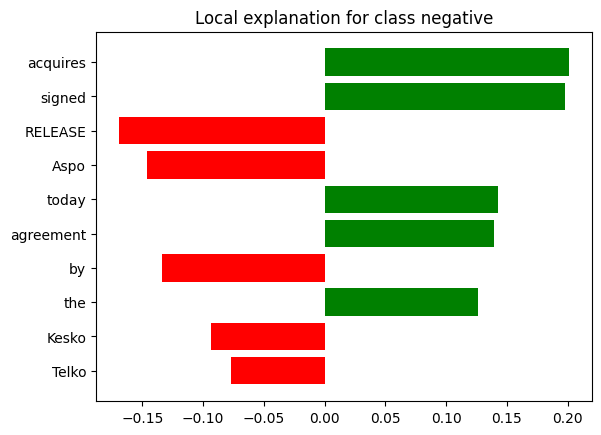

In [26]:
f = exp.as_pyplot_figure()